In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern32_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
data = pd.read_csv('../data/gp_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.DATE_IND = (data.DATE_IND - data.DATE_IND.mean()) / data.DATE_IND.std()

e_s = (5.36 / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.111666666667


In [5]:
search_periods = [
                 [5,12],
                 [12,12],
                 [24,12]]
                 

data.head()


,Unnamed: 0,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND
0,0,2013-06-02,1.0,0.0,8.556851,8.800599,-1.725120
1,48,2013-06-09,1.0,0.0,8.556851,8.800599,-1.711374
2,96,2013-06-16,1.0,0.0,8.556851,8.800599,-1.697628
3,144,2013-06-23,1.0,0.0,8.556851,8.800599,-1.683882
4,192,2013-06-30,1.0,0.0,8.556851,8.800599,-1.670136


Beginning run [5, 12] : 
Training ends on: 2017-02-05 00:00:00
testing ends on: 2017-04-30 00:00:00
using the safe Matern!
Initial neg. log-likelihood: -433.204311222
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 236.269314
  Number of iterations: 113
  Number of functions evaluations: 122
using the safe Matern!
using the safe Matern!
added gp pred and error to test
gp_sq_error    0.764423
0              1.366987
dtype: float64
Beginning run [12, 12] : 
Training ends on: 2017-03-26 00:00:00
testing ends on: 2017-06-18 00:00:00
using the safe Matern!
Initial neg. log-likelihood: -1050.36665915
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 500.146840
  Number of iterations: 187
  Number of functions evaluations: 197
using the safe Matern!
using the safe Matern!
added gp pred and error to test
gp_sq_error    0.7

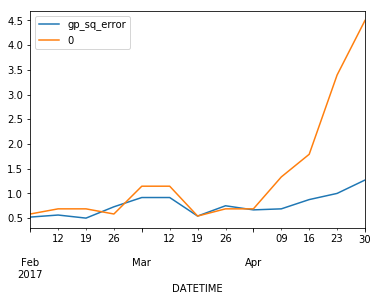

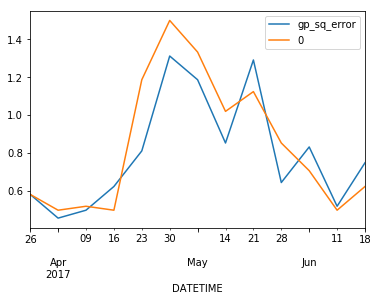

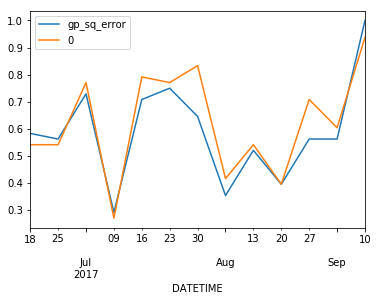

In [6]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/01/01', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Matern32_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


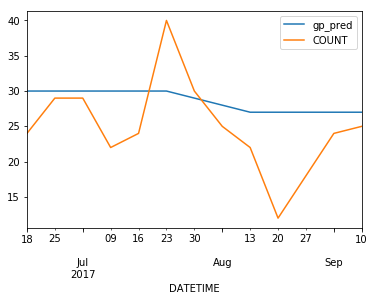

In [7]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()

In [8]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

GRID_SQUARE
33.0    45.0
44.0    19.0
21.0    17.0
35.0    17.0
36.0    16.0
Name: COUNT, dtype: float64

In [14]:
test[test.GRID_SQUARE == 45][['gp_pred','COUNT']]

,gp_pred,COUNT
DATETIME,,
2017-06-18,0.0,1.0
2017-06-25,0.0,0.0
2017-07-02,0.0,1.0
2017-07-09,0.0,0.0
2017-07-16,0.0,0.0
2017-07-23,0.0,0.0
2017-07-30,0.0,0.0
2017-08-06,0.0,1.0
2017-08-13,0.0,0.0
